

# `ibis` + `seaborn.objects`: Data Exploration

### Learning Goals

We are now ready to start assembling the information we have learned from our initial exploration and bring together our skills with `ibis` and `seaborn.objects`.

In [1]:
import ibis
from ibis import _
import ibis.selectors as s
import seaborn.objects as so 

con = ibis.duckdb.connect()

In [2]:
base_url = "https://huggingface.co/datasets/cboettig/ram_fisheries/resolve/main/v4.65/"
stock = con.read_csv(base_url + "stock.csv", nullstr="NA")
timeseries = con.read_csv(base_url + "timeseries.csv", nullstr="NA")

Last time we reached the conclusion that we wanted to average across multiple assessments:

In [3]:
cod_stocks = (
  timeseries
  .join(stock, "stockid")
  .filter(_.tsid == "TCbest-MT")
  .filter(_.commonname == "Atlantic cod")
  .group_by(_.tsyear, _.stockid, _.primary_country, _.primary_FAOarea)
  .agg(catch = _.tsvalue.mean())
)


This is great, but even after aggregating the assessments, we have a lot of individual cod stocks in various locations:

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

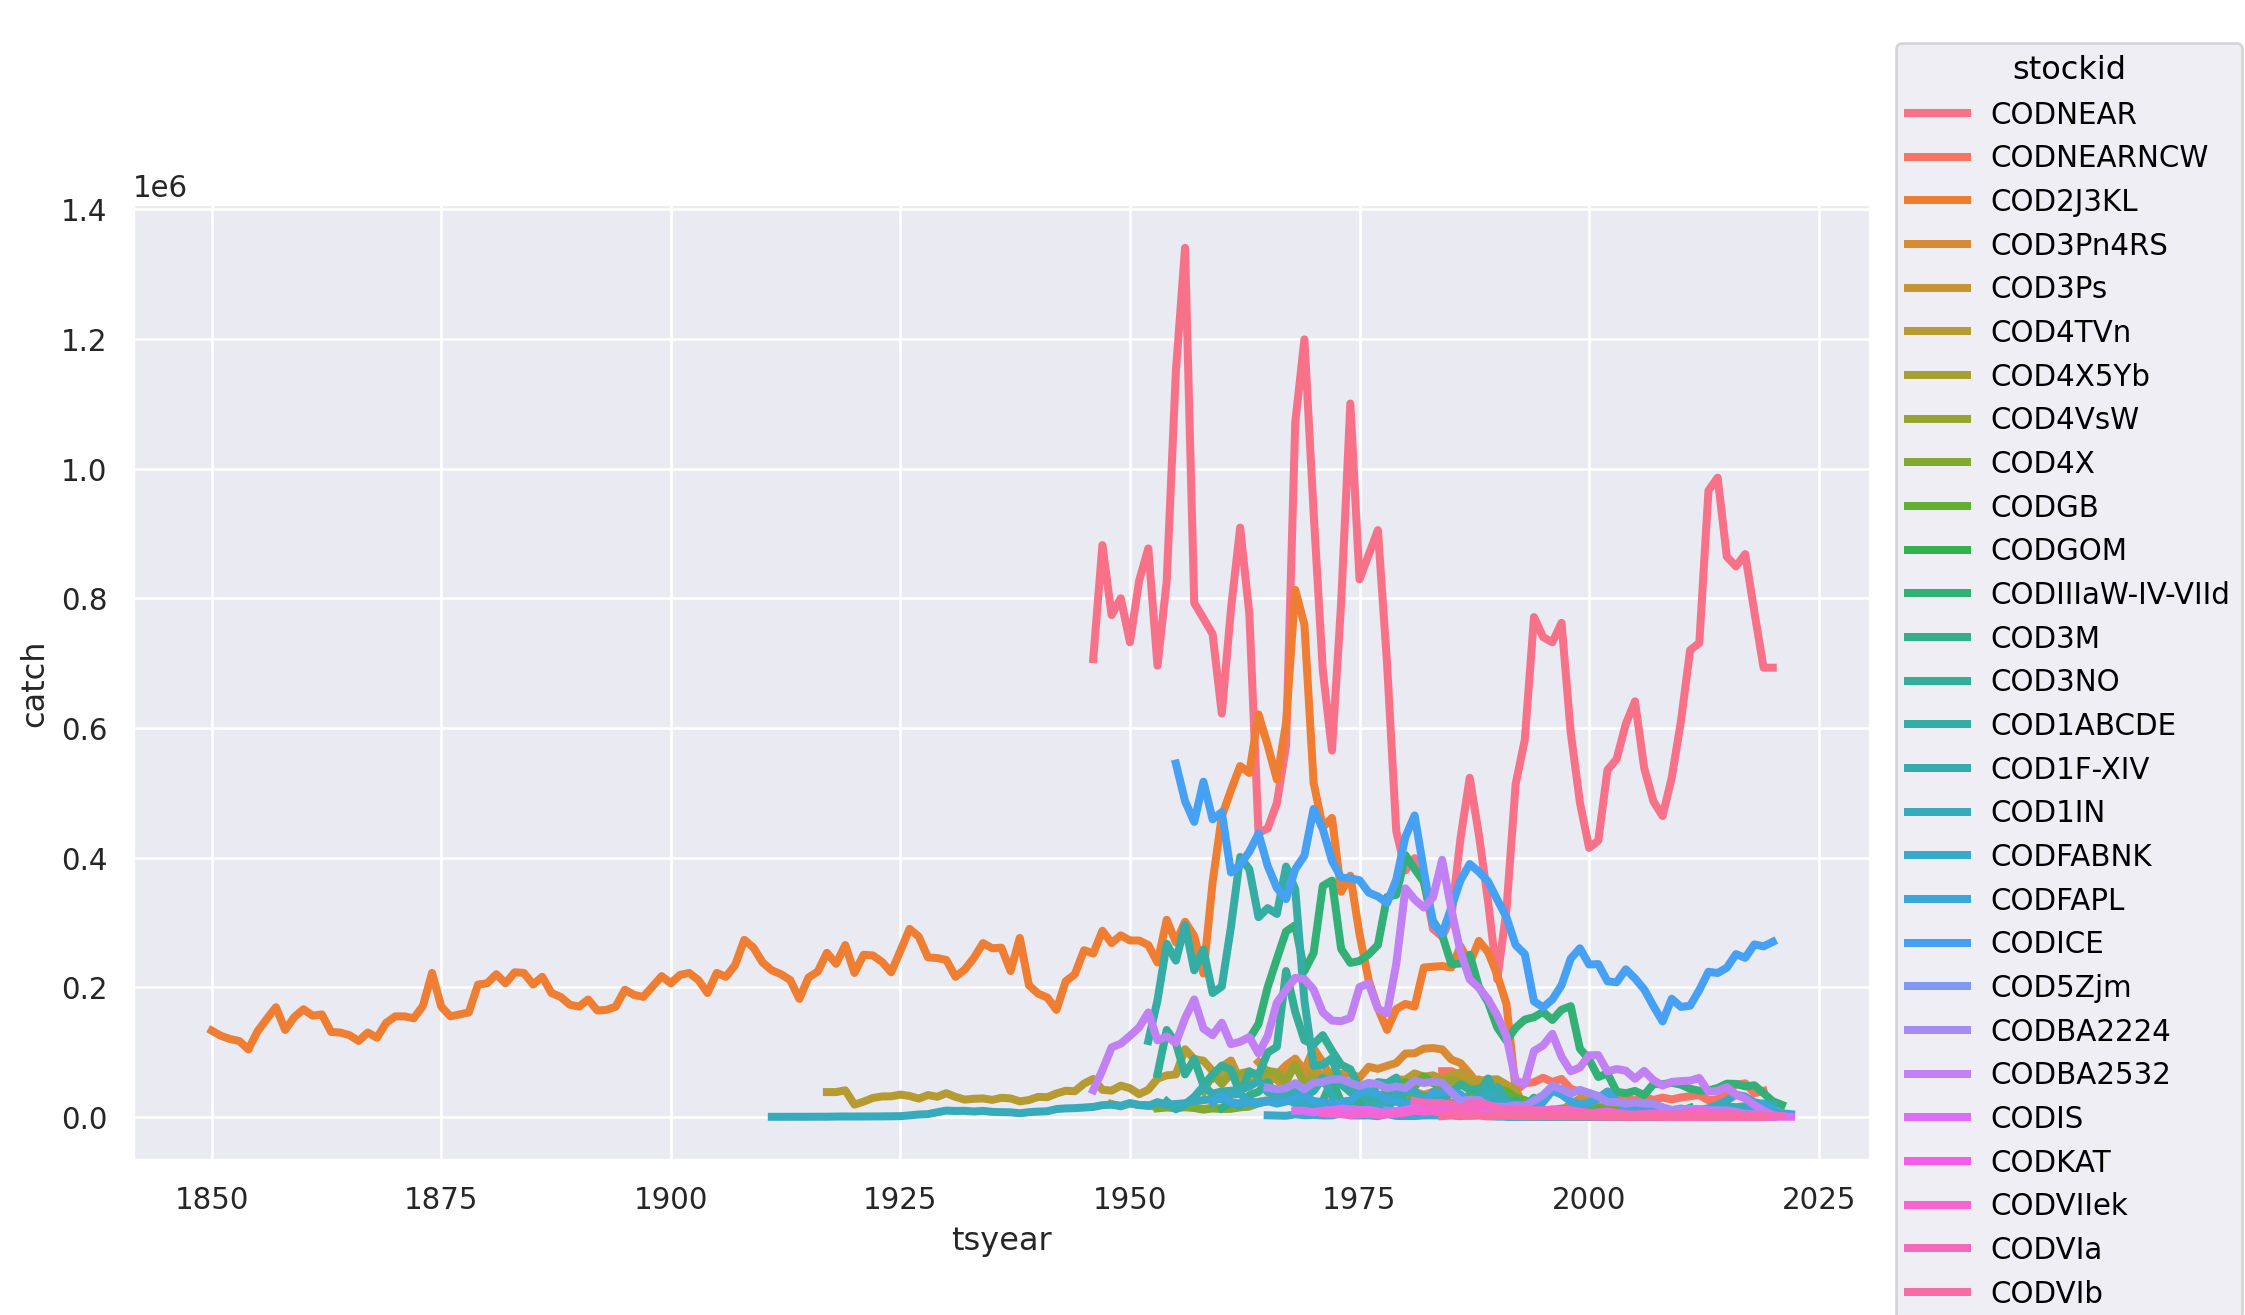

In [16]:
(
    so.Plot(cod_stocks, 
        x = "tsyear",
            y="catch",
            color = "stockid")
    .add(so.Lines(linewidth=3))
    .layout(size=(10, 6))
)

Our good friend, the `COD2J3KL` series shows up with it's remarkable declines, but what's going on with those highly variable but very large catches?  This will obviously impact our assessment of whether or not the species as a whole has collapsed.  This is too many stocks to easily explore, let's try breaking this out by at the by country:

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

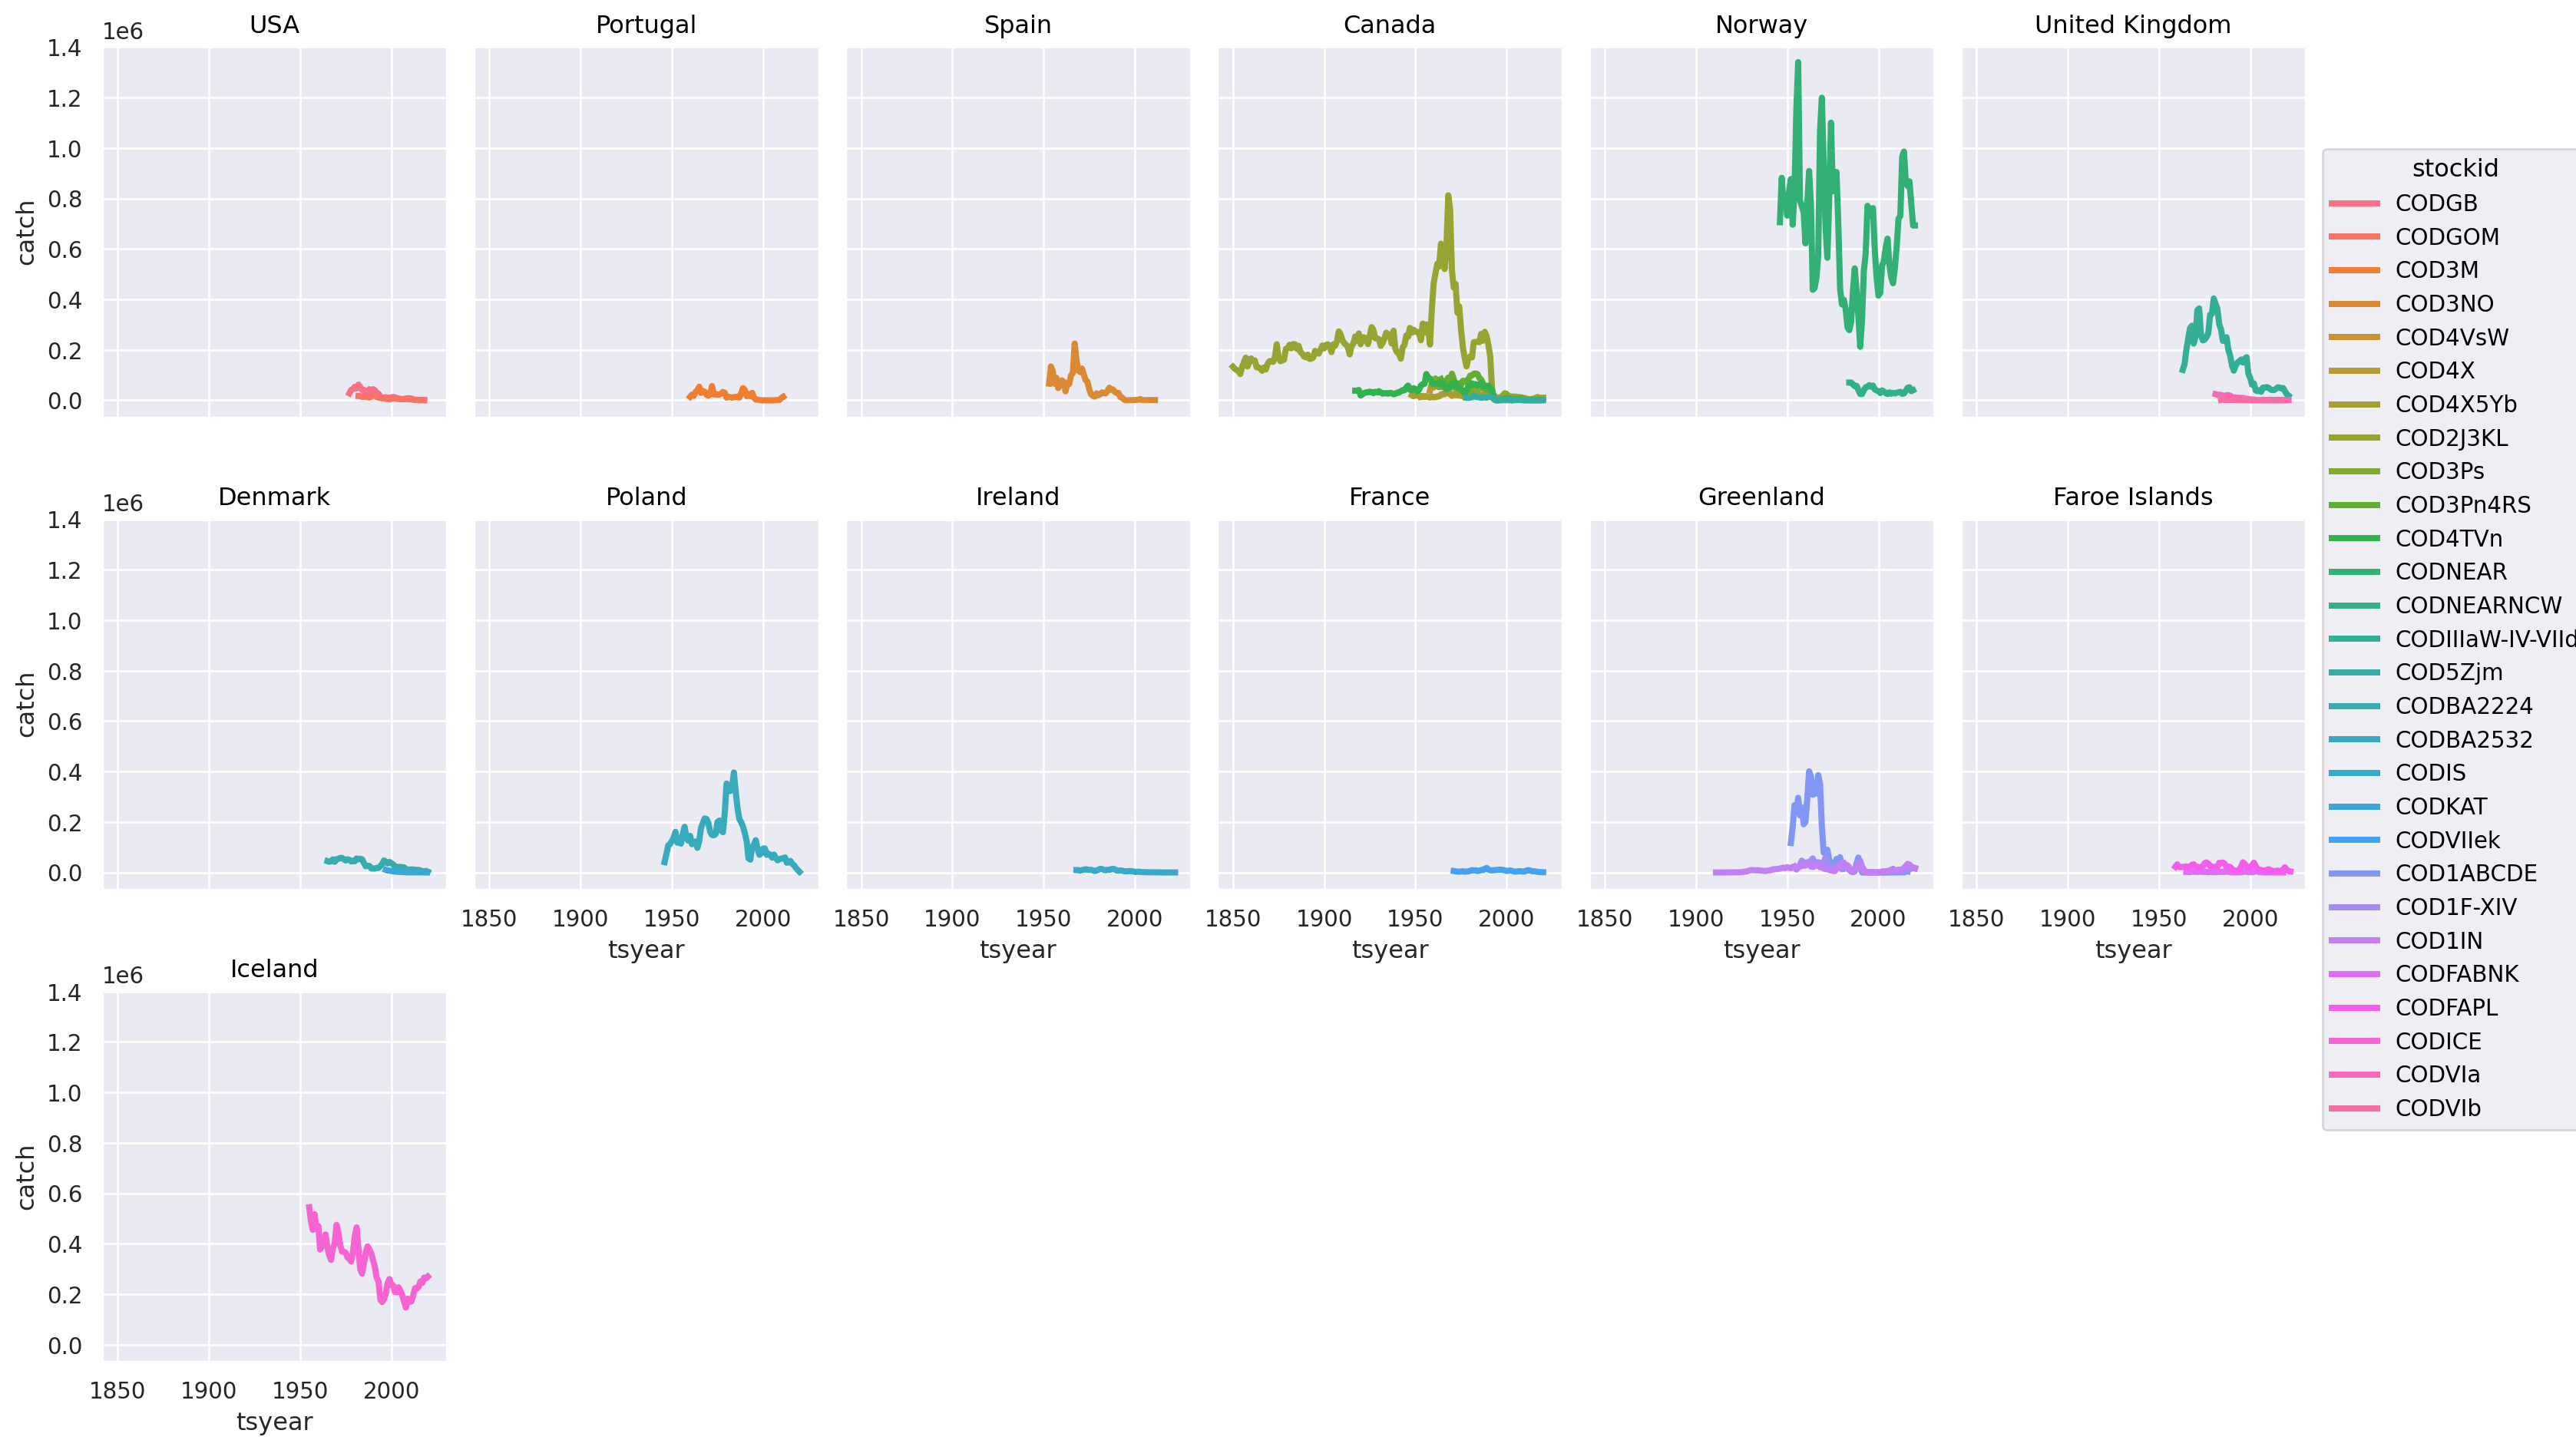

In [5]:
(
    so.Plot(cod_stocks, 
            x = "tsyear", 
            y="catch", 
            color = "stockid",
            group = "primary_country")
    .add(so.Lines(linewidth=3))
    .facet("primary_country", wrap = 6)
    .layout(size=(16, 10))
)

Note in the country-based graphs, several countries have multiple stocks.  Norway and Canada stand out for the largest harvests.  The 'grammar of graphics' in Seaborn objects makes it easy to quickly visually explore the data along different dimensions.  For instance, we can divide stocks by primary FAO Area instead of country with a single change:

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

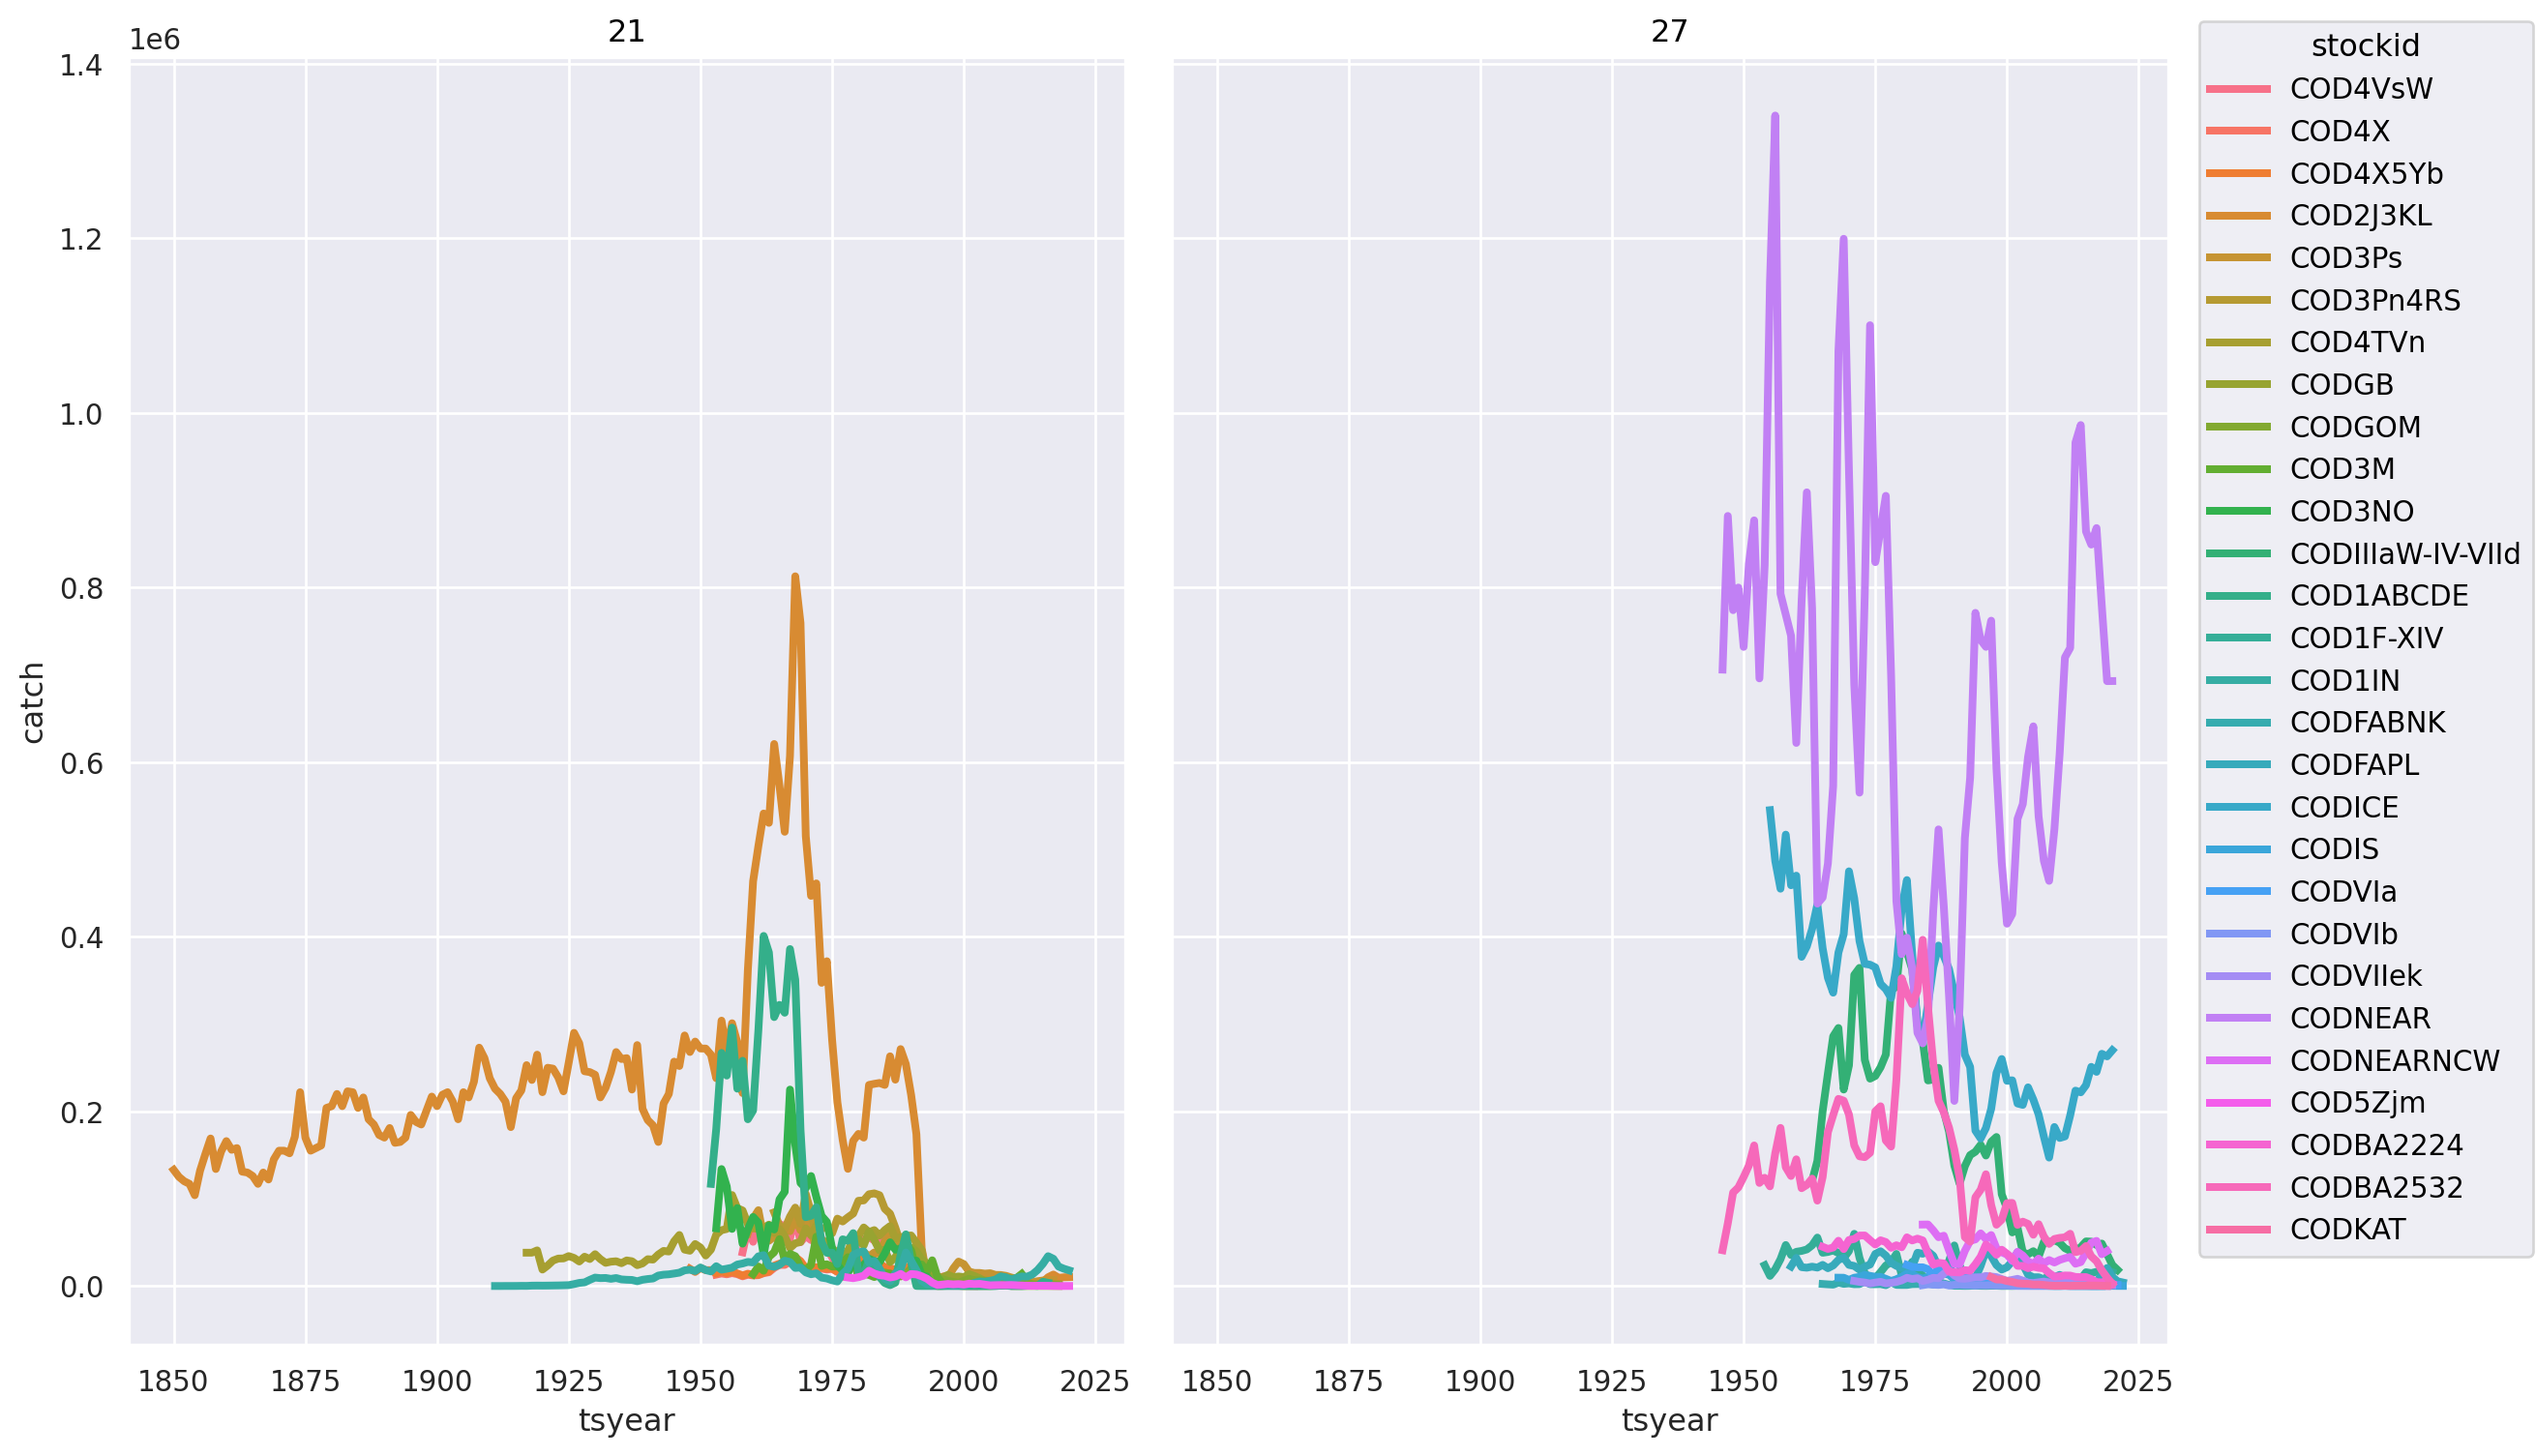

In [15]:
(
    so.Plot(cod_stocks, 
            x = "tsyear", 
            y="catch", 
            color = "stockid",
            group = "primary_FAOarea")
    .add(so.Lines(linewidth=3))
    .facet("primary_FAOarea")
    .layout(size=(12, 8))
)

We have visually grouped the data into the two parts of the globe where Atlantic Cod are found: "Western North-Atlantic" (FAO area 21) and "Eastern North-Atlantic" (area 27).  While we see declines in some Eastern stocks, the pattern in the West is much more dramatic.  If we want to consider the fate of Western Atlantic Cod as a whole, we can add up all these individual stocks to get a picture for the entire FAO Region.  We call the resulting table `cod_fao` because now it no longer reflects individual stocks, we have summed all the individual stocks up when we aggregated to the level of entire FAO regions.  

In [12]:
cod_fao = (cod_stocks
   .group_by(_.tsyear, _.primary_FAOarea)
   .agg(catch = _.catch.sum())
)

In [ ]:
Once again we can get a visual sense of the resulting aggrecations.  

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

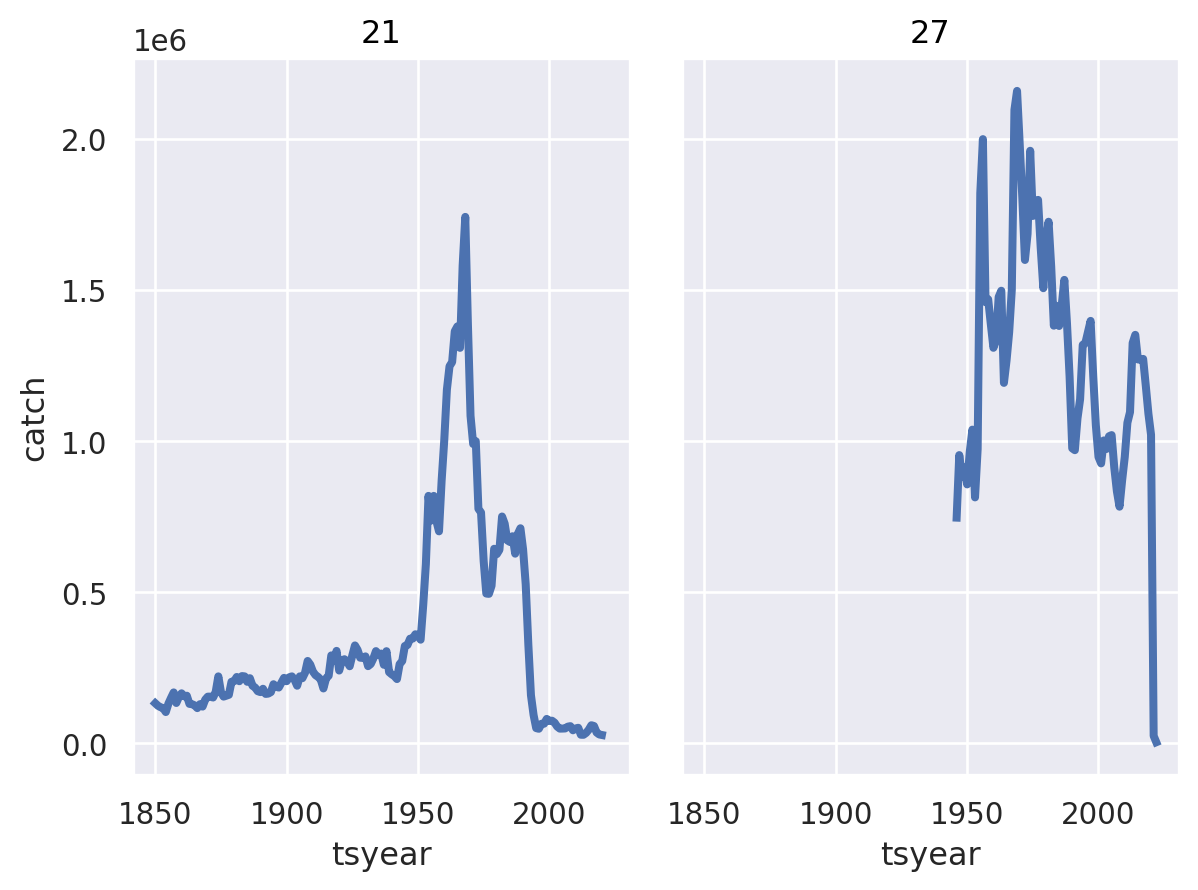

In [17]:
(
    so.Plot(cod_fao, 
            x = "tsyear", 
            y="catch")
    .add(so.Lines(linewidth=3))
    .facet("primary_FAOarea")
)